# Comparison of different scikit-learn regressors

We have pressure trace data from various $\xi$ samples, in the form of 3 coefficients of a sigmoid function

In [1]:
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from utils import load_all_data, normalise_data

/var/folders/6y/1gfy1yb96_59763zctgly20h0000gn/T/ipykernel_95157/1667796376.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [18]:
# First examine the data

dataset = np.load("processed_dataset.npz")
print(dataset.files)

['X_train', 'Y_train', 'time_train', 'X_test', 'Y_test', 'time_test']


In [19]:
X_train = dataset['X_train']
Y_train = dataset['Y_train']
X_test = dataset['X_test']
Y_test = dataset['Y_test']

scaler = MinMaxScaler()
Y_train = scaler.fit_transform(Y_train)
Y_test = scaler.transform(Y_test)

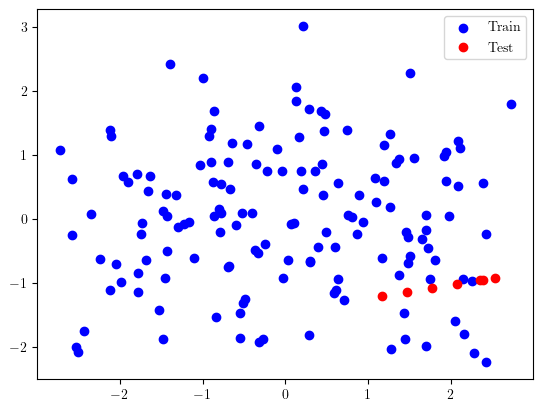

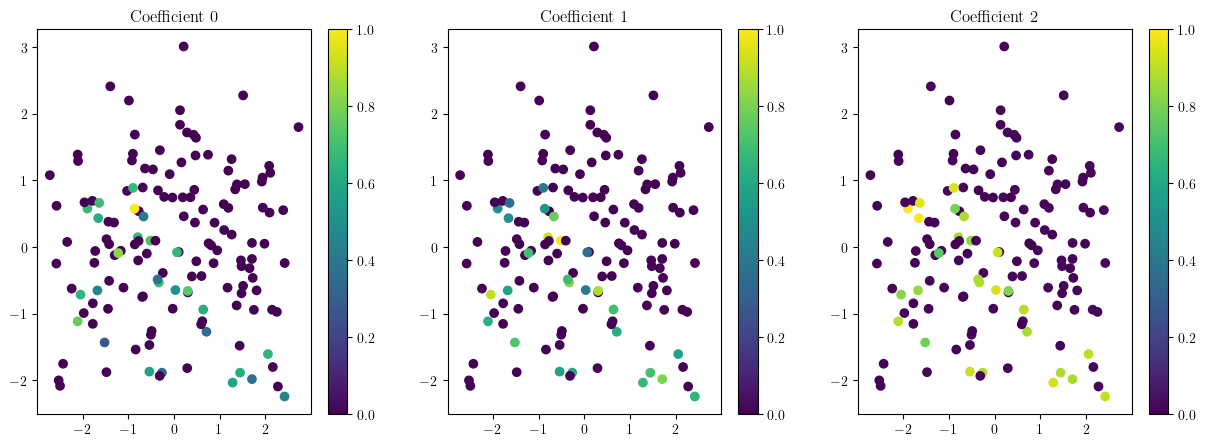

In [20]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

fig, ax = plt.subplots()
ax.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c='b', label='Train')
ax.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c='r', label='Test')
ax.legend()
plt.show()

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Set color scale based on Y_train[:, 0]
cmap = plt.get_cmap('viridis')

for i in range(3):
    ax = axs[i]
    sc = ax.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=Y_train[:, i], cmap=cmap, label='Train')
    #ax.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=Y_test[:, i], cmap=cmap, label='Test')
    ax.set_title(f'Coefficient {i}')
    fig.colorbar(sc)
plt.show()


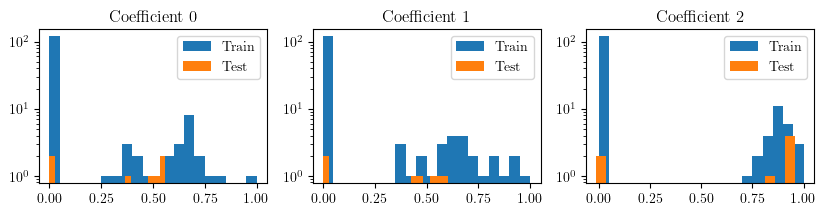

In [26]:
fig, axs = plt.subplots(1, 3, figsize=(10, 2))
for i in range(3):
    axs[i].hist(Y_train[:, i], bins=20, alpha=1, label='Train')
    axs[i].hist(Y_test[:, i], bins=20, alpha=1, label='Test')
    axs[i].set_title(f'Coefficient {i}')
    axs[i].set_yscale('log')
    axs[i].legend()

In [22]:
# Compare different regressor models

from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score

models = [MultiOutputRegressor(LinearRegression()),
          MLPRegressor(max_iter=10000, hidden_layer_sizes=(128, 128, 128), batch_size=128, learning_rate='adaptive', learning_rate_init=0.001, alpha=0.01, solver='adam', activation="relu"),
          KNeighborsRegressor(n_neighbors=1),
          RandomForestRegressor(n_estimators=100, max_depth=10, random_state=0)
          ]

model_names = ["LinearRegression", "MLP", "KNN", "RandomForest"]
mse_test = []
mse_train = []
r2_test = []
r2_train = []

# hacky trick to increase importance of "A" coefficient
#Y_train[:, 2] *= 10
#Y_test[:, 2] *= 10

for model in models:
    print(model)
    model.fit(X_train, Y_train)
    
    Y_pred = model.predict(X_test)
    mse_test.append(mean_squared_error(Y_test, Y_pred))
    r2_test.append(r2_score(Y_test, Y_pred))
    
    Y_pred = model.predict(X_train)
    mse_train.append(mean_squared_error(Y_train, Y_pred))
    r2_train.append(r2_score(Y_train, Y_pred))

MultiOutputRegressor(estimator=LinearRegression())
MLPRegressor(alpha=0.01, batch_size=128, hidden_layer_sizes=(128, 128, 128),
             learning_rate='adaptive', max_iter=10000)
KNeighborsRegressor(n_neighbors=1)
RandomForestRegressor(max_depth=10, random_state=0)


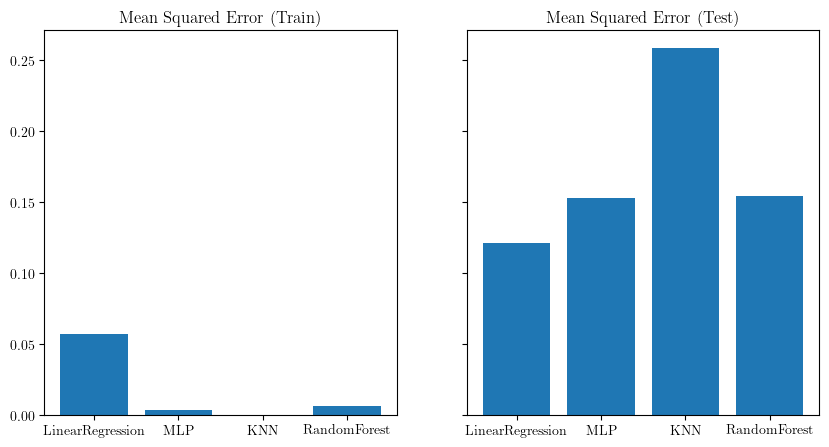

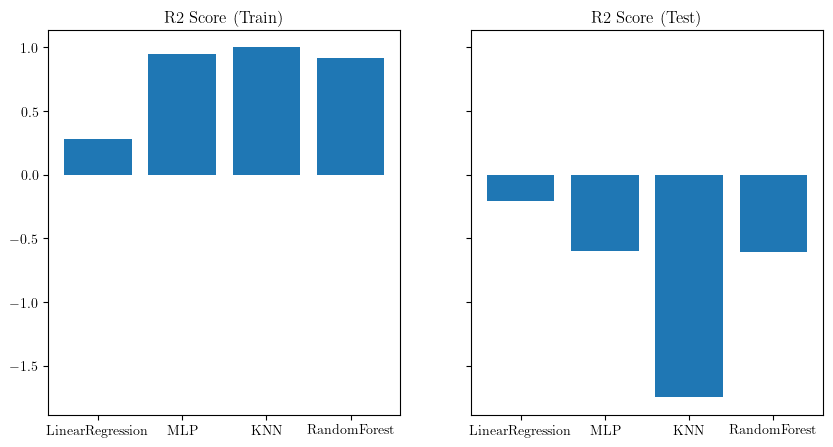

In [23]:
# Plot the results

fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
ax = axs[0]
ax.bar(model_names, mse_train, label='Train')
ax.set_title('Mean Squared Error (Train)')
ax = axs[1]
ax.bar(model_names, mse_test, label='Test')
ax.set_title('Mean Squared Error (Test)')

plt.show()

fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
ax = axs[0]
ax.bar(model_names, r2_train, label='Train')
ax.set_title('R2 Score (Train)')
ax = axs[1]
ax.bar(model_names, r2_test, label='Test')
ax.set_title('R2 Score (Test)')
plt.show()


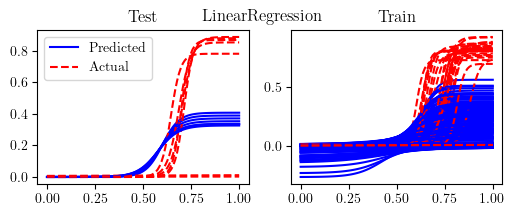

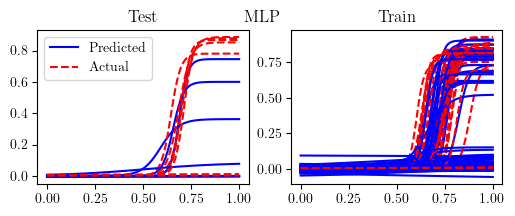

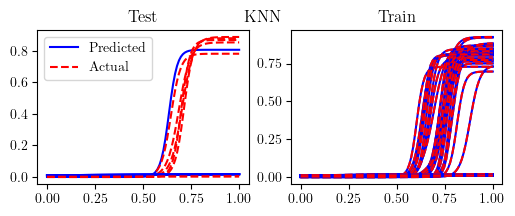

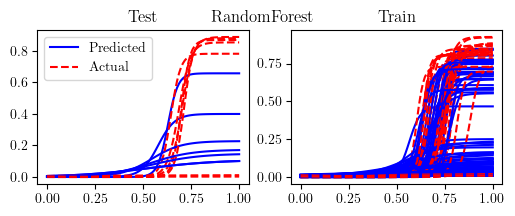

In [24]:
# Deeper analysis of one model

model = models[-2]

# Look at the predict vs actual sigmoids on the test set

def sigmoid(x, x0, k, A):
    return A / (1 + np.exp(-k * (x - x0)))


def plot_sigmoid_curves(model, model_name):
    fig, axs = plt.subplots(1, 2, figsize=(6, 2))
    ax = axs[0]
    Y_pred = model.predict(X_test)
    Y_pred = scaler.inverse_transform(Y_pred)
    for y_pred, y_true in zip(Y_pred, scaler.inverse_transform(Y_test)):
        x0, k, A = y_pred
        x = np.linspace(0, 1, 100)
        y = sigmoid(x, x0, k, A)
        ax.plot(x, y, c='b')

        x0, k, A = y_true
        y = sigmoid(x, x0, k, A)
        ax.plot(x, y, c='r', ls='--')
    # Manual legend
    ax.plot([], [], c='b', label='Predicted')
    ax.plot([], [], c='r', label='Actual', ls='--')
    ax.legend()
    ax.set_title("Test")
    ax = axs[1]
    Y_pred = model.predict(X_train)
    Y_pred = scaler.inverse_transform(Y_pred)
    for y_pred, y_true in zip(Y_pred, scaler.inverse_transform(Y_train)):
        x0, k, A = y_pred
        x = np.linspace(0, 1, 100)
        y = sigmoid(x, x0, k, A)
        ax.plot(x, y, c='b', label='Predicted')

        x0, k, A = y_true
        y = sigmoid(x, x0, k, A)
        ax.plot(x, y, c='r', label='Actual', ls='--')
    ax.set_title("Train")
    fig.suptitle(model_name)
    plt.show()


for model, model_name in zip(models, model_names):
    plot_sigmoid_curves(model, model_name)

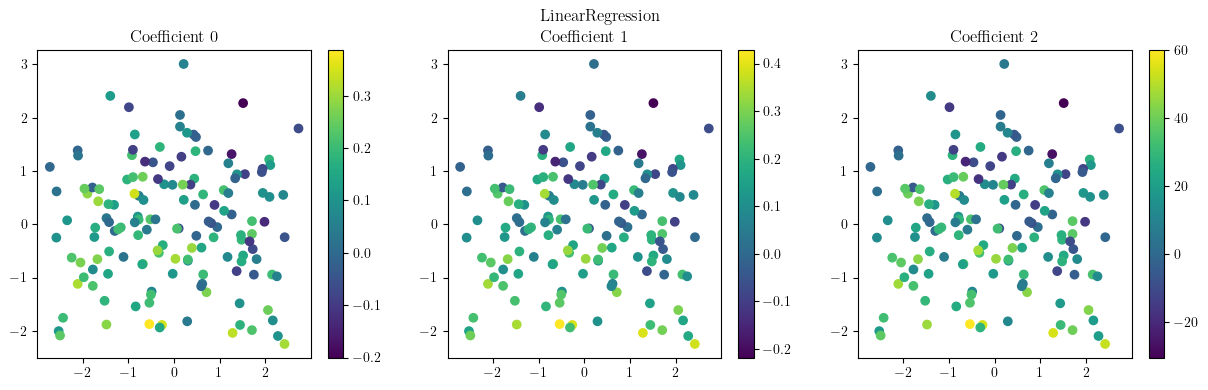

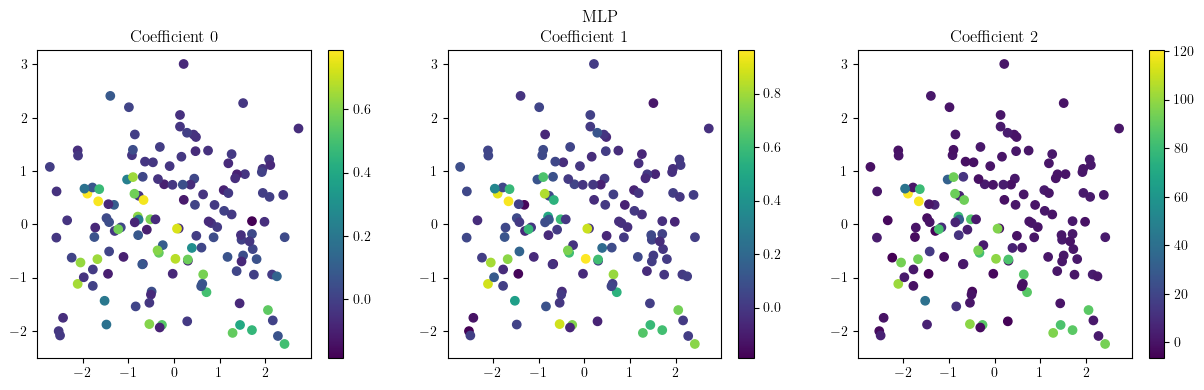

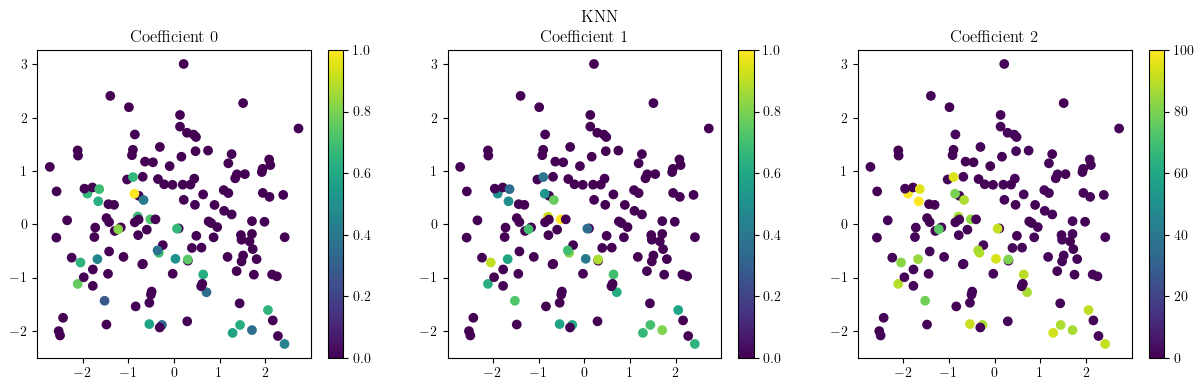

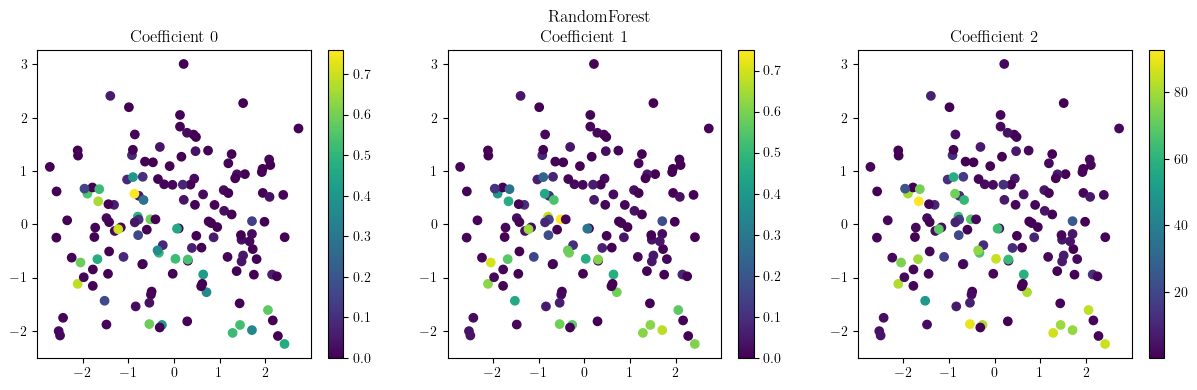

In [15]:
# For each output, plot the predicted values at each training point in PCA space, to visualise the function learned by the model

def visualise_regression_function(model, model_name):
    X_train_pca = pca.transform(X_train)
    cmap = plt.get_cmap('viridis')
    
    fig, axs = plt.subplots(1, 3, figsize=(15, 4))
    Y_pred = model.predict(X_train)
    for i in range(3):
        ax = axs[i]
        sc = ax.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=Y_pred[:, i], cmap=cmap, label='Predicted')
        ax.set_title(f'Coefficient {i}')
        fig.colorbar(sc)
        fig.suptitle(model_name)

for model, model_name in zip(models, model_names):
    visualise_regression_function(model, model_name)